In [6]:
#載入套件
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [7]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols)) #ceil() 函數返回不小於(nimg/ncols)的整數。
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    '''
    plt.subplots參數說明:
    nrows,ncols：整數，表示子圖網格(grid)的行數與列數。
    sharex,sharey：布林值(預設為Fals)e， 控制x(sharex)或y(sharey)軸之間的屬性共享。
    figsize:指定figure的寬和高，單位為英寸。
    '''
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [8]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

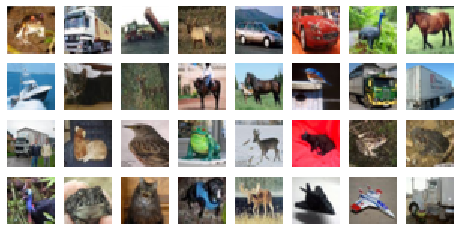

In [9]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [10]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,     #旋轉範圍為0~20度內進行隨機旋轉。
    width_shift_range=0.2, #水平平移20%pixels。
    height_shift_range=0.2,#垂直平移20%pixels。
    horizontal_flip=True) #隨機對圖片執行水平翻轉操作。

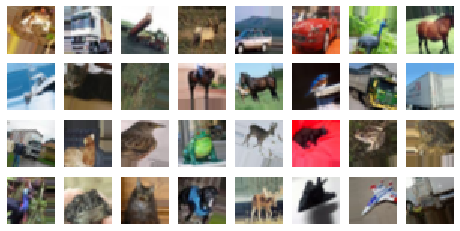

In [11]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False)) #shuffle:佈林值，是否對數據進行隨機洗牌。
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

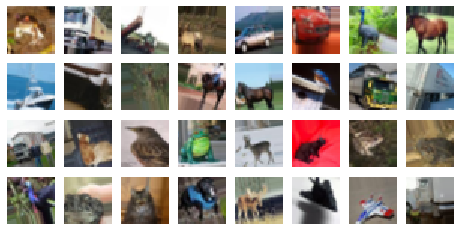

In [12]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False)) #shuffle:佈林值，是否對數據進行隨機洗牌。
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [1]:
#載入套件
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30 # 訓練的 epochs 數量，定義訓練週期

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
# Convert class vectors to binary class matrices.
# y 值轉成 one-hot encoding，轉成10類
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [2]:
# 建立簡單的線性執行的模型
model = Sequential()
# 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, padding='same'不足的空間用 0填充一列
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
# activation function 採用 relu
model.add(Activation('relu'))
# 建立卷積層，filter=32,,即 output size, Kernal Size: 3x3
model.add(Conv2D(32, (3, 3)))
# activation function 採用 relu
model.add(Activation('relu'))
# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))
# 隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.25))

# 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, padding='same'不足的空間用 0填充一列
model.add(Conv2D(64, (3, 3), padding='same'))
# activation function 採用 relu
model.add(Activation('relu'))
# 建立卷積層，filter=64,即 output size, Kernal Size: 3x3
model.add(Conv2D(64, (3, 3)))
# activation function 採用 relu
model.add(Activation('relu'))
# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))
# 隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.25))

# 把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
model.add(Flatten())
# 全連接層: 512個output
model.add(Dense(512))
# activation function 採用 relu
model.add(Activation('relu'))
# 隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.5
model.add(Dropout(0.5))
# 使用 softmax activation function，並將結果分類
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# 輸出模型概況
model.summary()

# 編譯: 選擇損失函數、優化方法及成效衡量方式
# 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
________________________________________________

In [3]:
from keras.preprocessing.image import ImageDataGenerator
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=5,     #旋轉範圍為0~5度內進行隨機旋轉。
    width_shift_range=0.05, #水平平移5%pixels。
    height_shift_range=0.05,#垂直平移5%pixels。
    horizontal_flip=True) #隨機對圖片執行水平翻轉操作。

# 訓練：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
# 訓練過程會存在 history 變數中
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=32),  #接收numpy和標籤為參數，生成通過數據提升或標準化後的batch數據，並在一個無限循環中不斷的返回batch數據
                              steps_per_epoch=len(x_train)/batch_size,   # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                              epochs=epochs, 
                              verbose=1, 
                              validation_data=(x_test, y_test))

# 顯示損失函數、訓練成果(分數)
# verbose：日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄。
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
391/390 [==============================] - 9s 23ms/step - loss: 1.9045 - accuracy: 0.3022 - val_loss: 1.6082 - val_accuracy: 0.4165
Epoch 2/30
391/390 [==============================] - 7s 17ms/step - loss: 1.5880 - accuracy: 0.4217 - val_loss: 1.3579 - val_accuracy: 0.5063
Epoch 3/30
391/390 [==============================] - 6s 16ms/step - loss: 1.4352 - accuracy: 0.4813 - val_loss: 1.2992 - val_accuracy: 0.5287
Epoch 4/30
391/390 [==============================] - 7s 17ms/step - loss: 1.3509 - accuracy: 0.5139 - val_loss: 1.1895 - val_accuracy: 0.5699
Epoch 5/30
391/390 [==============================] - 7s 18ms/step - loss: 1.2667 - accuracy: 0.5516 - val_loss: 1.1761 - val_accuracy: 0.5745
Epoch 6/30
391/390 [==============================] - 6s 15ms/step - loss: 1.2253 - accuracy: 0.5655 - val_loss: 1.1518 - val_accuracy: 0.5993
Epoch 7/30
391/390 [==============================] - 6s 17ms/step - loss: 1.2120 - accuracy: 